In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from bold_dementia.utils.configuration import get_config
from neuroginius.atlas import Atlas
from neuroginius.plotting import plot_matrix

config = get_config()

conn_dir = config["connectivity_matrices"]
ATLAS = "schaefer200"

atlas = Atlas.from_name(ATLAS, soft=False)

In [3]:
import joblib
import pandas as pd
import numpy as np


def make_longitudinal_data(conn_dir, atlas, k):
    matrices = joblib.load(f"{conn_dir}/atlas-{atlas}_gpugin/connectivities.joblib")
    metadata = pd.read_csv(f"{conn_dir}/atlas-{atlas}_gpugin/metadata.csv", index_col=0)
    labels = pd.read_csv(f"/georges/memento/BIDS/cluster_{k}_labels.csv", index_col=0)


    metadata = metadata.merge(
        right=labels,
        how="left", # Preserves order of the left key
        on="NUM_ID",
        validate="many_to_one"
    )

    no_psych_mask = metadata.cluster_label.isna()
    print(
        f"Dropping {no_psych_mask.sum()} subjects because of lacking MMMSE"
    )

    metadata = metadata[np.logical_not(no_psych_mask)]
    matrices = matrices[np.logical_not(no_psych_mask)]

    return matrices, metadata

In [4]:
matrices, metadata = make_longitudinal_data(conn_dir, "schaefer200", 3)
metadata = metadata.reset_index(drop=True)

Dropping 22 subjects because of lacking MMMSE


In [5]:
# We look for subjects which have all the timesteps
end_msk = (metadata.cluster_label == 1) & (metadata.ses == "M048")
middle_msk = (metadata.cluster_label == 1) & (metadata.ses == "M024")
start_msk = (metadata.cluster_label == 1) & (metadata.ses == "M000")

end_subjects = metadata.loc[end_msk, "sub"].values
middle_subjects = metadata.loc[middle_msk, "sub"].values
start_subjects = metadata.loc[start_msk, "sub"].values

complete_subjects = sorted(
    tuple(set(list(end_subjects)).intersection(set(start_subjects)).intersection(set(middle_subjects)))
)

complete_subj_msk = metadata["sub"].isin(complete_subjects)
idx_48 = metadata[(metadata.ses == "M048") & complete_subj_msk].index.values
idx_24 = metadata[(metadata.ses == "M024") & complete_subj_msk].index.values
idx_00 = metadata[(metadata.ses == "M000") & complete_subj_msk].index.values


In [63]:
estimators = []
for i in range(8):
    estimators.append(joblib.load(f"output/estimator_{i}.joblib"))
    

In [109]:
from scipy.special import expit

class EnsembleClassifier:
    """
    Ensemble already fitted models
    """
    def __init__(self, models) -> None:
        self.models = models

    def predict_proba(self, X):
        n_preds = len(X)
        predictions = []
        for model in self.models:
            # We cannot use predict proba as it tends to
            # give nans for some reason
            predictions.append(expit(model.decision_function(X)))

        predictions = np.stack(predictions, axis=0).mean(axis=0)
        probas = predictions / predictions.sum(axis=1).reshape((n_preds, 1))
        return probas

In [110]:
eclf = EnsembleClassifier(estimators)
preds = eclf.predict_proba(matrices)

In [38]:
from nilearn.connectome import sym_matrix_to_vec
steep_mask = (joblib.load('output/haufe_steep.joblib'))# - joblib.load('output/haufe_slow.joblib')) * 1000
slow_mask = (joblib.load('output/haufe_slow.joblib'))# - joblib.load('output/haufe_slow.joblib')) * 1000
stable_mask = (joblib.load('output/haufe_stable.joblib'))# - joblib.load('output/haufe_slow.joblib')) * 1000

M000 = []
M024 = []
M048 = []

for mat_mask in (stable_mask, slow_mask, steep_mask):

    pos_msk = np.where(mat_mask > 0, mat_mask, 0)
    neg_msk = np.where(mat_mask < 0, mat_mask, 0)
    feats_48 = sym_matrix_to_vec((matrices[idx_48, ...] * mat_mask)).mean(axis=1)
    feats_24 = sym_matrix_to_vec((matrices[idx_24, ...] * mat_mask)).mean(axis=1)
    feats_00 = sym_matrix_to_vec((matrices[idx_00, ...] * mat_mask)).mean(axis=1)
    M000.append(feats_00)
    M024.append(feats_24)
    M048.append(feats_48)

M000 = pd.DataFrame(np.stack(M000).T, columns=["stable", "slow", "steep"])
M000["timestep"] = "M000"
M024 = pd.DataFrame(np.stack(M024).T, columns=["stable", "slow", "steep"])
M024["timestep"] = "M024"
M048 = pd.DataFrame(np.stack(M048).T, columns=["stable", "slow", "steep"])
M048["timestep"] = "M048"
df = pd.concat((M000, M024, M048))

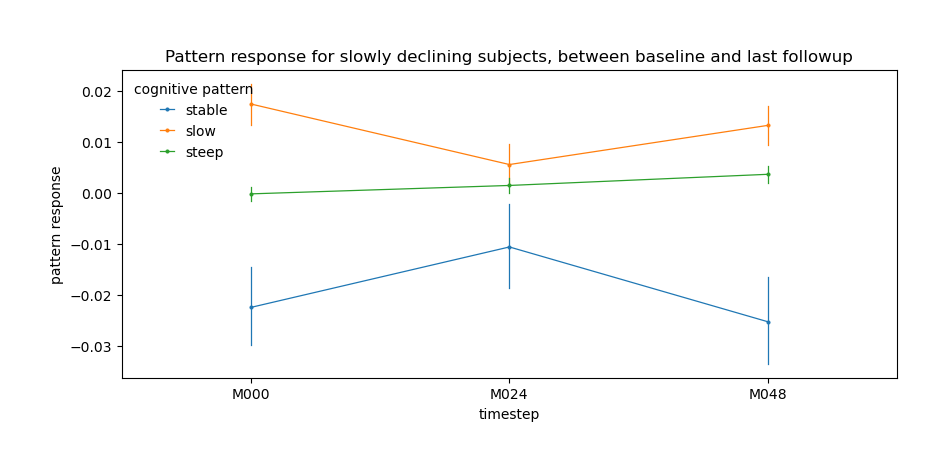

In [48]:
import seaborn as sns
plt.subplots(figsize=(10, 4))
m = df.melt(id_vars="timestep", value_name="pattern response", var_name="cognitive pattern")
sns.pointplot(m, x="timestep", y="pattern response", hue="cognitive pattern", alpha=1)
plt.title("Pattern response for slowly declining subjects, between baseline and last followup")
plt.show()

In [60]:
sample_a = df.loc[df.timestep == "M000", "steep"]
sample_b = df.loc[df.timestep == "M048", "steep"]

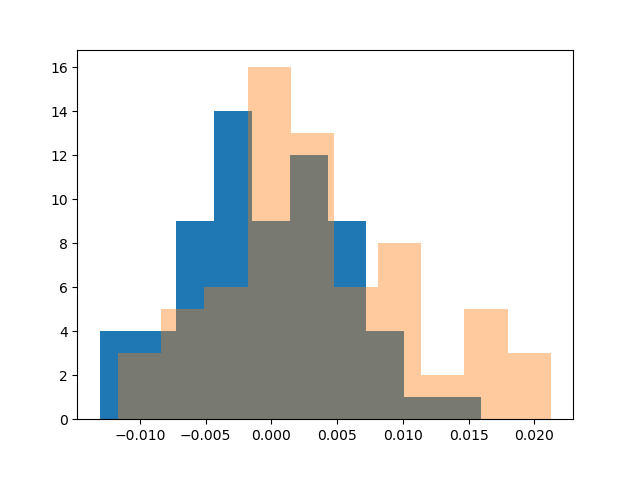

TtestResult(statistic=np.float64(-3.22185774231688), pvalue=np.float64(0.0016214559456876163), df=np.float64(125.87044420318868))

In [61]:
from scipy.stats import ttest_ind
plt.hist(sample_a)
plt.hist(sample_b, alpha=0.4)
plt.show()
ttest_ind(sample_a, sample_b, equal_var=False)